# Публичное решение задачи матчинга VTB DataFusion Contest 2022

In [ ]:
#!pip install catboost
#!pip install shap

In [3]:
import pandas as pd
import numpy as np
import gc
import pickle
import shap
from catboost import CatBoostClassifier, CatBoostRanker, Pool

# Загрузка и создание эмбеддингов по данным кликстрима

In [5]:
chunksize = 10 ** 6
tmp_lst = []
with pd.read_csv('data/clickstream.csv', index_col='user_id', parse_dates=['timestamp'], dtype={
    'user_id': 'category', 'cat_id': 'int16', 'new_uid': 'int32' 
}, chunksize=chunksize) as reader:
    for chunk in reader:
        tmp_lst.append(chunk)
clickstream = pd.concat(tmp_lst) 
del tmp_lst

In [6]:
# добавляем столбцы date, hour, weekday
clickstream['date'] = clickstream['timestamp'].dt.date.astype('category')
clickstream['hour'] = clickstream['timestamp'].dt.hour.astype('category')
clickstream['weekday'] = clickstream['timestamp'].dt.dayofweek.astype('category')

In [7]:
# Генерим фичи из бэйзлайна
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                            values=['timestamp'],
                            columns=['cat_id'],
                            aggfunc=['count']).fillna(0)

In [8]:
clickstream_embed2 = clickstream.pivot_table(index = 'user_id', 
                            values=['timestamp'],
                            columns=['date'],
                            aggfunc=['count']).fillna(0)

In [9]:
# Добавляем колличество уникальных устройств пользователя
clickstream_embed3 = clickstream.pivot_table(index = 'user_id', 
                            values=['new_uid'],
                            aggfunc=['nunique']).fillna(0)

In [10]:
# разница между первым и последним входом
clickstream_embed4 = clickstream.groupby('user_id')['timestamp'].apply(lambda x: np.max(x) - np.min(x)).dt.days.astype('int16').to_frame()

In [11]:
# активность в конкретный час дня недели
clickstream_embed5 = clickstream.pivot_table(index = 'user_id', 
                            values=['timestamp'],
                            columns=['weekday','hour'],
                            aggfunc=['count']).fillna(0)

In [12]:
clickstream_embed.columns = [f'rtk-{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]
clickstream_embed2.columns = [f'rtk-{str(i[0])}-{str(i[2])}' for i in clickstream_embed2.columns]
clickstream_embed3.columns = [f'rtk-{str(i[0])}-{str(i[1])}' for i in clickstream_embed3.columns]
clickstream_embed4.columns = [f'rtk-max_date_diff' for i in clickstream_embed4.columns]
clickstream_embed5.columns = [f'rtk-{str(i[0])}-weekday-{str(i[2])}-nhour-{str(i[3])}' for i in clickstream_embed5.columns]

In [13]:
clickstream_embed = clickstream_embed.merge(clickstream_embed2, left_on='user_id', right_index=True).merge(
                                            clickstream_embed3, left_on='user_id', right_index=True).merge(
                                            clickstream_embed4, left_on='user_id', right_index=True).merge(
                                            clickstream_embed5, left_on='user_id', right_index=True)

clickstream_embed.loc[0] = np.empty(len(clickstream_embed.columns)) # добавляем user_id = 0

del clickstream, clickstream_embed2, clickstream_embed3, clickstream_embed4, clickstream_embed5
gc.collect()

# оптимизация памяти из бэйзлайна (думаю можно на SparseDtype заменить)
dtype_clickstream = list()
for x in clickstream_embed.dtypes.tolist():
    if x == 'int64' or x == 'int32' or x == 'int16':
          dtype_clickstream.append('int16')
    elif x == 'float64' or x == 'float32':
          dtype_clickstream.append('float32')
    else:
          dtype_clickstream.append('object')

dtype_clickstream = dict(zip(clickstream_embed.columns.tolist(),dtype_clickstream))
clickstream_embed = clickstream_embed.astype(dtype_clickstream)

# Загрузка и создание эмбеддингов по данным транзакций банка

In [14]:
transactions = pd.read_csv('data/transactions.csv', index_col='user_id', 
                           parse_dates=['transaction_dttm'], 
                           dtype={
    'user_id': 'category', 'mcc_code': 'int16', 'currency_rk': 'int8', 'transaction_amt': 'float32' 
})

In [15]:
# добавляем столбцы date, hour, weekday
transactions['date'] = transactions['transaction_dttm'].dt.date.astype('category')
transactions['hour'] = transactions['transaction_dttm'].dt.hour.astype('category')
transactions['weekday'] = transactions['transaction_dttm'].dt.dayofweek.astype('category')

In [16]:
# Фичи из бэйзлайна
bankclient_embed = transactions.pivot_table(index = 'user_id', 
                            values=['transaction_amt'],
                            columns=['mcc_code'],
                            aggfunc=['sum', 'mean', 'count']).fillna(0)
bankclient_embed.columns = [f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]

In [17]:
# Добавляем фичи по валютам транзакции
bankclient_embed2 = transactions.pivot_table(index = 'user_id', 
                            values=['transaction_amt'],
                            columns=['currency_rk'],
                            aggfunc=['sum', 'mean', 'count']).fillna(0)
bankclient_embed2.columns = [f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed2.columns]

In [18]:
bankclient_embed3 = transactions.pivot_table(index = 'user_id', 
                            values=['transaction_dttm'],
                            columns=['date'],
                            aggfunc=['count']).fillna(0)
bankclient_embed3.columns = [f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed3.columns]

In [19]:
bankclient_embed4 = transactions.pivot_table(index = 'user_id', 
                            values=['transaction_dttm'],
                            columns=['weekday','hour'],
                            aggfunc=['count']).fillna(0)
bankclient_embed4.columns = [f'bnk-{str(i[0])}-weekday-{str(i[2])}-nhour-{str(i[3])}' for i in bankclient_embed4.columns]

In [20]:
bankclient_embed5 = transactions.groupby('user_id')['transaction_dttm'].apply(lambda x: np.max(x) - np.min(x)).dt.days.astype('int16').to_frame()
bankclient_embed5.columns = [f'bnk-max_date_diff' for i in bankclient_embed5.columns]

In [21]:
bankclient_embed = bankclient_embed.merge(bankclient_embed2, left_on='user_id', right_index=True
                                         ).merge(bankclient_embed3, left_on='user_id', right_index=True
                                                ).merge(bankclient_embed4, left_on='user_id', right_index=True)

del transactions, bankclient_embed2, bankclient_embed3, bankclient_embed4
gc.collect()

dtype_bankclient = list()
for x in bankclient_embed.dtypes.tolist():
    if x == 'int64' or x == 'int32' or x == 'int16':
        dtype_bankclient.append('int16')
    elif x == 'float64' or x == 'float32':
        dtype_bankclient.append('float32')
    else:
        dtype_bankclient.append('object')
    
dtype_bankclient = dict(zip(bankclient_embed.columns.tolist(),dtype_bankclient))
bankclient_embed = bankclient_embed.astype(dtype_bankclient)

# Загрузка и подготовка трэйна

In [23]:
tr_match = pd.read_csv('data/train_matching.csv')

In [24]:
# собираем списки уникальных id клиентов банка и РТК 
list_of_rtk = list(clickstream_embed.index.unique())
list_of_bank= list(bankclient_embed.index.unique())
len(list_of_bank), len(list_of_rtk)

(22533, 19624)

In [25]:
#склеиваем трэйн 
train = tr_match.merge(bankclient_embed, how='left', left_on='bank', right_index=True
                                        ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)

In [26]:
# добавляем колонку с таргетами
train['match'] = 1

In [27]:
#запускаем, если захочется выкинуть все матчинги с 0
train = train.loc[train['rtk'] != '0']

### Обнаружение и удаление выбросов
Так как предварительный просмотр данных показал наличие значительных выбросов по некоторым признакам, реализованы 2 функции для обнаружения и очистки датасета от них.</br>
Регулируется гипер-параметром k. </br>
IQR - хуже ищет выбросы, быстрее работает </br>
SDM - лучше ищет, медленнее работает </br>

In [28]:
full_list_of_features = [col for col in train.columns][2:-1]

In [29]:
from numpy import percentile
from tqdm.notebook import tqdm
import copy
def drop_outliers_iqr(data, features, k=20, verbose=True):
    data_size_before = len(data)
    source_data = copy.deepcopy(data)
    for i in tqdm(features):
        q25, q75 = percentile(source_data[i], 25), percentile(source_data[i], 75)
        if not q25 or not q75:
            continue
        iqr = q75 - q25
        cut_off = iqr * k
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = [x for x in source_data[i] if x < lower or x > upper]
        if outliers:
            data = data.loc[(data[i] >= lower) & (data[i] <= upper)]
            if verbose:
                print(f'Identified outliers in {i}: {len(outliers)}; Len dataset: {len(data)}')
    print(f'Removed outliers: {data_size_before - len(data)}')
    print(f'Dataset size before: {data_size_before}; Dataset size after: {len(data)}')
    data = data.reset_index(drop=True)
    return data

In [30]:
from numpy import std, mean
import copy
from tqdm.notebook import tqdm
def drop_outliers_sdm(data, features, k=10, verbose=True):
    data_size_before = len(data)
    source_data = copy.deepcopy(data)
    for i in tqdm(features):
        data_mean, data_std = mean(source_data[i]), std(source_data[i])
        cut_off = data_std * k
        lower, upper = data_mean - cut_off, data_mean + cut_off
        outliers = [x for x in source_data[i] if x < lower or x > upper]
        if outliers:
            data = data.loc[(data[i] >= lower) & (data[i] <= upper)]
            if verbose:
                print(f'Identified outliers in {i}: {len(outliers)}; Len dataset: {len(data)}')
    print(f'Removed outliers: {data_size_before - len(data)}')
    print(f'Dataset size before: {data_size_before}; Dataset size after: {len(data)}')
    data = data.reset_index(drop=True)
    return data

In [31]:
# Использование
#train = drop_outliers_iqr(train, full_list_of_features)

# Негативы
Для реализации негативных матчингов можно использовать рандомную функцию из бэзлайна или воспользоваться функцией генерации "умных" негативов - наиболее близких по косинусному расстоянию соседей к сматченной паре. Чтобы Catboost учился находить минимальные различия между парами или для 2-х этапной модели.

In [32]:
# функция генерации негативных матчингов из бэйзлайна
def gen_random_for_negative(x, k, list_of_uniq):
    while True:
        final_list = np.random.choice(list_of_uniq, size=k, replace=False)
        if x not in final_list:
            return final_list

In [33]:
# собираем negative train
tr_match = train[['bank', 'rtk']]
tr_match['negatives'] = tr_match['rtk'].apply(lambda x: gen_random_for_negative(x, 10, list_of_rtk))
neg_train = tr_match[['bank', 'negatives']].explode('negatives')
neg_train.columns = tr_match.columns[:-1]
neg_train = neg_train.merge(bankclient_embed, how='left', left_on='bank', right_index=True
                                        ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
neg_train['match'] = 0 # добавляем 0 таргеты


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
# функция генерации умных негативов
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=1, metric="cosine")

def get_smart_negatives(x, k, list_of_rtk, bnk_embed, rtk_embed, train):
    temp = pd.DataFrame([x], columns=['bank'])
    temp['rtk'] = temp['bank'].apply(lambda x: list_of_rtk)
    temp = temp[['bank', 'rtk']].explode('rtk')
    temp = temp.merge(bnk_embed, how='left', left_on='bank', right_index=True
                                        ).merge(rtk_embed, how='left', left_on='rtk', right_index=True).fillna(0)
    knn.fit(temp.iloc[:, 2:])
    ind = knn.kneighbors(train.loc[train['bank'] == x].iloc[:, 2:-1], k + 1, return_distance=False)
    return [list_of_rtk[i] for i in ind[0][1:]]

In [35]:
# Для ускорения генерации применимим библиотеку pandarallel
# На платформе Kaggle занимает порядка 4-х часов
'''from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)
# собираем smart negative train
tr_match = train[['bank', 'rtk']]
tr_match['negatives'] = tr_match['bank'].parallel_apply(lambda x: get_smart_negatives(x, 10, list_of_rtk, bankclient_embed, clickstream_embed, train))
smart_neg_train = tr_match[['bank', 'negatives']].explode('negatives')
smart_neg_train.columns = tr_match.columns[:-1]
smart_neg_train = smart_neg_train.merge(bankclient_embed, how='left', left_on='bank', right_index=True
                                        ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
smart_neg_train['match'] = 0 # добавляем 0 таргеты'''

"from pandarallel import pandarallel\npandarallel.initialize(progress_bar=True, nb_workers=4)\n# собираем smart negative train\ntr_match = train[['bank', 'rtk']]\ntr_match['negatives'] = tr_match['bank'].parallel_apply(lambda x: get_smart_negatives(x, 10, list_of_rtk, bankclient_embed, clickstream_embed, train))\nsmart_neg_train = tr_match[['bank', 'negatives']].explode('negatives')\nsmart_neg_train.columns = tr_match.columns[:-1]\nsmart_neg_train = smart_neg_train.merge(bankclient_embed, how='left', left_on='bank', right_index=True\n                                        ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)\nsmart_neg_train['match'] = 0 # добавляем 0 таргеты"

In [36]:
# собираем позитивы и негативы в зависимости от примененной функции
train = pd.concat((train, neg_train), ignore_index=True)
train['match'].value_counts()

0    146710
1     14671
Name: match, dtype: int64

In [37]:
# Оптимизируем трэйн по памяти
dtype_train = list()
for x in train.dtypes.tolist():
    if x == 'int64' or x == 'int16':
        dtype_train.append('int16')
    elif x == 'float64' or x == 'float32':
        dtype_train.append('float32')
    else:
        dtype_train.append('object')
    
dtype_train = dict(zip(train.columns.tolist(),dtype_train))
train = train.astype(dtype_train)

In [38]:
# сохраняем трэйн
with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

In [39]:
# здесь можно загрузить трэйн из файла, чтобы пропустить все предыдущие шаги
#with open('./trainBaseline', 'rb') as file:
    #train = pickle.load(file)

In [40]:
# сохраняем список фичей для отправки решения
full_list_of_features = [col for col in train.columns][2:-1]
with open('full_list_of_features', 'wb') as file:
    pickle.dump(full_list_of_features, file)

In [41]:
del neg_train, tr_match
gc.collect()

153

# Обучение моделей

In [42]:
# делим на тренировочную и валидационную выборки
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train[full_list_of_features], train['match'], 
                                                       train_size=0.8, 
                                                       random_state=33)

## CatBoost Classifier

In [43]:
# Определяем параметры модели
model = CatBoostClassifier(random_seed=9,
                           iterations=5000,
                           learning_rate=0.01,
                           l2_leaf_reg=3,
                           depth=5,
                           #task_type="GPU", # раскомментить, когда с GPU
                           thread_count=-1,
                           use_best_model=True,
                           leaf_estimation_method='Newton',
                           custom_loss=['Precision', 'Recall', 'F1', 'AUC']
                                             )

In [44]:
# запуск обучения
model.fit(X_train, y_train,
                    eval_set=(X_val, y_val),
                    verbose=500, plot=False, early_stopping_rounds=600)

print(model.get_best_score())

0:	learn: 0.6837722	test: 0.6838065	best: 0.6838065 (0)	total: 790ms	remaining: 1h 5m 51s
500:	learn: 0.2964935	test: 0.3008738	best: 0.3008736 (499)	total: 6m 2s	remaining: 54m 11s
1000:	learn: 0.2862908	test: 0.2924108	best: 0.2924108 (1000)	total: 12m 32s	remaining: 50m 7s
1500:	learn: 0.2802244	test: 0.2880381	best: 0.2880365 (1499)	total: 18m 38s	remaining: 43m 26s
2000:	learn: 0.2748741	test: 0.2843848	best: 0.2843842 (1999)	total: 24m 51s	remaining: 37m 15s
2500:	learn: 0.2703462	test: 0.2816418	best: 0.2816418 (2500)	total: 31m 11s	remaining: 31m 9s
3000:	learn: 0.2661250	test: 0.2793837	best: 0.2793837 (3000)	total: 37m 22s	remaining: 24m 53s
3500:	learn: 0.2622468	test: 0.2774179	best: 0.2774179 (3500)	total: 43m 42s	remaining: 18m 42s
4000:	learn: 0.2587695	test: 0.2758244	best: 0.2758244 (4000)	total: 49m 51s	remaining: 12m 27s
4500:	learn: 0.2553675	test: 0.2742999	best: 0.2742998 (4499)	total: 56m 5s	remaining: 6m 13s
4999:	learn: 0.2523419	test: 0.2730515	best: 0.2730515

In [45]:
# Отберем 300 наиболее важных фичей и обучим на них CBRanker
fi = model.get_feature_importance(prettified=True)
important_features = list(fi['Feature Id'][:300])
fi[:50]

,Feature Id,Importances
0,rtk-count-weekday-6-nhour-1,3.516595
1,rtk-count-772,2.721433
2,rtk-count-weekday-0-nhour-18,1.718224
3,rtk-count-weekday-5-nhour-1,1.330998
4,rtk-count-592,1.293891
5,bnk-count-weekday-5-nhour-0,1.283373
6,bnk-count-weekday-4-nhour-23,1.162061
7,rtk-count-weekday-1-nhour-19,1.084663
8,rtk-count-289,1.077049
9,rtk-count-weekday-0-nhour-19,1.013602


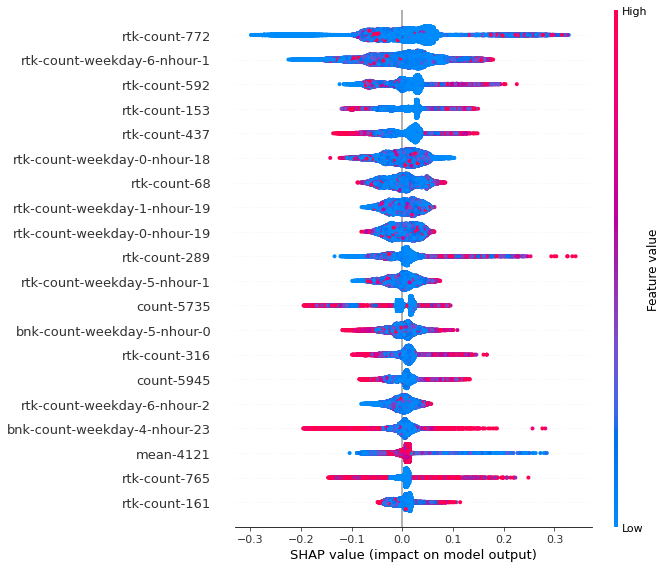

In [46]:
val_pool = Pool(X_val, y_val)
shap_values = model.get_feature_importance(val_pool, type='ShapValues')[:, :-1]
shap.summary_plot(shap_values, X_val)

In [47]:
# сохраняем список важных фичей для отправки решения
with open('important_features_300', 'wb') as file:
    pickle.dump(important_features, file)

In [48]:
del X_train, X_val, y_train, y_val, val_pool, shap_values
gc.collect()

9180

## CatBoost Ranker

In [49]:
# Сортируем трэйн и разбиваем на 2 выборки для Ранкера
train = train.sort_values(by=['bank'])
list_of_uniq_bank = train['bank'].unique()
train_size = int(0.8 * len(list_of_uniq_bank))
test = train[train['bank'].isin(list_of_uniq_bank[train_size:])]
train = train[train['bank'].isin(list_of_uniq_bank[:train_size])]

In [50]:
train_pool = Pool(
    data=train[important_features],
    label=train['match'].values,
    group_id=train['bank'].values
)

test_pool = Pool(
    data=test[important_features],
    label=test['match'].values,
    group_id=test['bank'].values
)

In [51]:
rank_model = CatBoostRanker(random_seed=9,
                            iterations=8000,
                            learning_rate=0.01,
                            l2_leaf_reg=14,
                            depth=4,
                            #task_type="GPU", # раскомментить, когда с GPU
                            thread_count=-1,
                            use_best_model=True,
                            random_strength=1,
                            leaf_estimation_method='Newton',
                            loss_function="QuerySoftMax",
                            custom_metric=['AverageGain:top=1','Recall', "Precision", 'MRR', 'AUC'],
                                             )

In [52]:
rank_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=1000,
                    verbose=500, plot=False)

print(rank_model.get_best_score())

0:	learn: 2.3975780	test: 2.3976128	best: 2.3976128 (0)	total: 244ms	remaining: 32m 29s
500:	learn: 2.2357235	test: 2.2508035	best: 2.2508035 (500)	total: 1m 29s	remaining: 22m 14s
1000:	learn: 2.1481426	test: 2.1763439	best: 2.1763439 (1000)	total: 2m 57s	remaining: 20m 42s
1500:	learn: 2.0797311	test: 2.1221150	best: 2.1221150 (1500)	total: 4m 26s	remaining: 19m 13s
2000:	learn: 2.0257037	test: 2.0834308	best: 2.0834308 (2000)	total: 5m 55s	remaining: 17m 44s
2500:	learn: 1.9842434	test: 2.0557632	best: 2.0557632 (2500)	total: 7m 22s	remaining: 16m 12s
3000:	learn: 1.9500716	test: 2.0345790	best: 2.0345790 (3000)	total: 8m 49s	remaining: 14m 42s
3500:	learn: 1.9185152	test: 2.0164444	best: 2.0164444 (3500)	total: 10m 21s	remaining: 13m 18s
4000:	learn: 1.8901437	test: 2.0011835	best: 2.0011835 (4000)	total: 11m 47s	remaining: 11m 47s
4500:	learn: 1.8617509	test: 1.9859694	best: 1.9859694 (4500)	total: 13m 14s	remaining: 10m 17s
5000:	learn: 1.8356726	test: 1.9730825	best: 1.9730825 (

In [53]:
# Посмотрим на 50 предсказаний Ранкера
# Как видно, метод predict выдает числа от -10 до 10, а не классы 1, 0
for i, j in zip (rank_model.predict(test[important_features].iloc[10:60,:]), test.iloc[10:60,-1]):
    print(i , j)

0.3901774103261323 0
-3.342571425268801 0
0.31012327763741315 0
0.058324864900840726 0
0.23721323378947043 0
0.22303807636320788 1
-1.4289561762950174 0
-1.69825053004126 0
-0.5979910453309863 0
0.2968094659440819 0
-0.43615611916199154 0
-0.9713502739464743 0
1.324119776080129 1
0.18746497578227253 0
0.8284055115332418 0
-0.09979317280825913 0
1.2708382792946407 0
-1.6394669342088801 0
-2.1043458023764328 0
-1.4112586367250721 0
-2.3455202652483713 0
-1.0064451834894141 0
0.41995394761149996 0
0.4115117403145248 0
0.22426059987719996 0
0.08480660285507986 0
0.5503248617539814 0
0.6648207688826423 1
-0.24350329625978792 0
-0.19518465724411238 0
-1.5948725497911116 0
0.12599523907734747 0
-1.5189922168643668 0
0.43954664672145666 0
-0.2214912428095266 0
-0.8735483226179565 0
-0.7819111349517732 0
-3.195371861087849 0
1.4173535878386223 0
0.16055376006001082 0
-0.018074161210143457 0
0.8459852599213015 0
-0.11620093119911795 0
1.4634700919855945 1
-1.210571238108203 0
-0.2336770480933472

In [54]:
rank_model.save_model('./rank_model.cbm',
           format="cbm",
           export_parameters=None,
           pool=None)

# Локальная валидация
Посчитаем метрики для локальной валидации модели

In [55]:
# формируем эмбединги для транзакций и кликстрима
banklist_val_embed = test.iloc[:,2:bankclient_embed.shape[1]+2]
banklist_val_embed['bank'] = [f'{i+1}_bank' for i in range(len(banklist_val_embed))]

clickstream_val_embed = test.iloc[:,bankclient_embed.shape[1]+2:]
clickstream_val_embed['rtk'] = [f'{i+1}_rtk' for i in range(len(clickstream_val_embed))]

In [56]:
# соответствия между транзакциями и кликстримами
matching_df = pd.DataFrame(data={'bank': banklist_val_embed['bank'].values,
                                 'rtk': clickstream_val_embed['rtk'].values,
                                 'match': test['match']}) # match обозначает наличие соответствия bank-rtk

clickstream_val_embed.set_index('rtk', inplace=True)
banklist_val_embed.set_index('bank', inplace=True)
matching_df = matching_df[matching_df['match'] == 1] # оставляем транзакции, у которых есть пара кликстима

In [57]:
list_of_rtk = list(matching_df['rtk'].values)
list_of_bank = list(matching_df['bank'].values)

### Метрики

In [58]:
def Precision_at100(preds, target):
    
    return np.mean([1 if t in p[1][:100] else 0 for p, t in zip(preds, target)])


def MRR_at100(preds, target):
    
    return np.mean([1/(p[1][:100].index(t)+1) if t in p[1][:100] else 0
                    for p, t in zip(preds, target)])

def R1(preds, target):
    '''
    Params:
    preds: numpy.ndarray which contains
           structures: [vtb_user, [candidates...]]
    target: list of values
    '''
    precision = Precision_at100(preds,target)
    mrr = MRR_at100(preds, target)
    R1 = 2*precision*mrr/(precision+mrr)
    print('Precision@100:', precision, 'MRR@100:',
                 mrr, 'R1:', R1)
    return R1

In [59]:
# инференс на валидационных данных; случай, в котором все транзакции имеют соответствие кликстрима
submission_val = []
submission = pd.DataFrame(matching_df['bank'], columns=['bank'])
submission['rtk'] = submission['bank'].apply(lambda x: list_of_rtk)

batch_size = 50
num_of_batches = int((len(banklist_val_embed))/batch_size)+1

for i in range(num_of_batches):
    bank_ids = list_of_bank[(i*batch_size):((i+1)*batch_size)]
    if len(bank_ids) != 0:
        part_of_submit = submission[submission['bank'].isin(bank_ids)].explode('rtk')
        part_of_submit = part_of_submit.merge(banklist_val_embed, how='left', left_on='bank', right_index=True
                                    ).merge(clickstream_val_embed, how='left', left_on='rtk', right_index=True).fillna(0)
        for i in full_list_of_features:
            if i not in part_of_submit.columns:
                part_of_submit[i] = 0
        
        # у Ранкера нет метода predict_proba!
        part_of_submit['predicts'] = rank_model.predict(part_of_submit[full_list_of_features])
        
        part_of_submit = part_of_submit.sort_values(by=['bank', 'predicts'], ascending=False).reset_index(drop=True)
        part_of_submit = part_of_submit.pivot_table(index='bank', values='rtk', aggfunc=list)
        part_of_submit['rtk'] = part_of_submit['rtk'].apply(lambda x: x[:100])
        part_of_submit['bank'] = part_of_submit.index
        part_of_submit = part_of_submit[['bank', 'rtk']]
        submission_val.extend(part_of_submit.values)

targets = [matching_df[matching_df['bank']==x[0]]['rtk'].values[0] for x in submission_val]
r1 = R1(submission_val, targets)

Precision@100: 0.2221465076660988 MRR@100: 0.024659928571836097 R1: 0.044392010962369166
